<a href="https://colab.research.google.com/github/Lamiaka/GNN_amld2022/blob/main/Simple_DNN_Example_%7C_GNN_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple DNN Example

# README

This is an example colab for Graph Neural Networks for Strucutred Data Workshop @ AMLD by volodya@google.com

Link to this colab: https://bit.ly/gnn-str-ex1


In [ ]:
from datetime import date
import pandas as pd
import tensorflow as tf
import numpy as np
import os

from sklearn.preprocessing import StandardScaler

In [ ]:
!wget 'https://drive.google.com/uc?id=1m3ACccA3GLg5GFg0D9khUNnt_c10gBAK&export=download' -O stocks-with-label_3days.prq

--2022-03-26 21:52:27--  https://drive.google.com/uc?id=1m3ACccA3GLg5GFg0D9khUNnt_c10gBAK&export=download
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.113, 74.125.195.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g19qh2478l6f7dom328kjuub74bu2n43/1648331550000/01333786639642341364/*/1m3ACccA3GLg5GFg0D9khUNnt_c10gBAK?e=download [following]
--2022-03-26 21:52:30--  https://doc-08-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g19qh2478l6f7dom328kjuub74bu2n43/1648331550000/01333786639642341364/*/1m3ACccA3GLg5GFg0D9khUNnt_c10gBAK?e=download
Resolving doc-08-5c-docs.googleusercontent.com (doc-08-5c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08-5c-docs.googleusercontent.com (doc-08-5c-docs

In [ ]:
stocks_df = pd.read_parquet('stocks-with-label_3days.prq')

## Explore the dataset

In [ ]:
stocks_df.head(10)

,ticker,Date,LABEL,High,Low,Close,Open,High_1,Low_1,Close_1,Open_1
147348,DIS,1991-04-01,1.025953,7.218523,7.112256,7.127438,7.218523,7.279250,7.226117,7.226117,7.241298
23857,NFLX,2011-08-24,1.045937,31.428572,29.928572,30.861429,31.291430,31.392857,29.155714,31.362858,29.571428
76492,WMT,2015-03-09,0.987933,71.751297,71.062544,71.355263,71.105587,71.544652,70.924770,71.105568,71.294977
100623,MSFT,2006-12-05,0.996064,21.573974,21.302465,21.375845,21.544622,21.662038,21.405204,21.522614,21.449232
99527,MSFT,2002-07-31,0.942984,15.208497,14.688873,15.202160,15.084928,15.471478,14.996212,15.240181,15.065917
6641,SONY,1999-06-08,1.057229,44.786081,44.487308,44.726326,44.726326,44.457423,44.128773,44.308037,44.188528
138733,NVDA,2016-07-21,1.030380,13.350371,13.047793,13.092072,13.308551,13.409413,13.156034,13.338074,13.210154
150940,DIS,2005-06-28,0.974879,21.150602,20.866429,20.996336,20.915144,21.231795,20.679688,20.809595,21.142483
149439,DIS,1999-07-09,1.015855,21.337273,20.906700,21.145908,21.289431,21.480797,21.193748,21.289431,21.480797
16626,UL,2002-02-06,1.012819,9.340154,9.246554,9.255063,9.280591,9.416739,9.252230,9.252230,9.416739


In [ ]:
# Converting categorical column 'ticker' (stock code) to a number.
ticker_column = pd.Categorical(stocks_df['ticker'])
stocks_df['ticker'] = ticker_column
stocks_df['ticker'] = stocks_df.ticker.cat.codes

In [ ]:
split_config = {
    'test_dt': pd.Timestamp('2020-01-01'), # 2020 onwards goes into test.
    'valid_dt': pd.Timestamp('2015-01-01'),
}

test_df = stocks_df.query('Date >= @test_dt', local_dict=split_config).copy()
train_df = stocks_df.query('Date < @valid_dt', local_dict=split_config).copy()
valid_df = stocks_df.query('Date >= @valid_dt and Date < @test_dt', local_dict=split_config).copy()

# Fitting the scaller on train
std_scaler = StandardScaler()

columns_to_scale = list(set(train_df.columns) - {'Date', 'ticker', 'LABEL'})
print('Scaling columns: ', columns_to_scale)

def convert_df(df, fit_scaler=False):
  df.pop('Date')
  df.pop('ticker')
  label =  df.pop('LABEL')
  label = (label > 1.01).astype(int) # Conver to binary

  df.fillna(-1, inplace=True)

  for c, d in zip(df.columns, df.dtypes):
    if d == np.float64:
      df[c].astype('float32', copy=False)
  
  scaler_func = std_scaler.fit_transform if fit_scaler else std_scaler.transform
  df[columns_to_scale] = scaler_func(df[columns_to_scale])

  dataset = tf.data.Dataset.from_tensor_slices((df[df.columns].values, label.values))
  return dataset, df, label

train_ds, train_df, train_target = convert_df(train_df, fit_scaler=True)
valid_ds, valid_df, valid_target = convert_df(valid_df, fit_scaler=False)

print('Train label: ', train_target.value_counts())
print('Valid label', valid_target.value_counts())

Scaling columns:  ['Open_1', 'Low', 'Low_1', 'Close_1', 'High_1', 'Open', 'Close', 'High']
Train label:  0    92337
1    46923
Name: LABEL, dtype: int64
Valid label 0    19886
1     9048
Name: LABEL, dtype: int64


In [ ]:
activation = tf.keras.layers.LeakyReLU()
num_units = 16
num_layers = 2
dropout = 0.2
batch_size = 1024
max_epochs = 4

layers = []
for _ in range(num_layers - 1):
  layers.append(tf.keras.layers.Dense(num_units, activation=activation))
  if dropout < 1:
    layers.append(tf.keras.layers.Dropout(rate=dropout))
layers.append(tf.keras.layers.Dense(num_units, activation=activation))

model = tf.keras.Sequential([
  *layers,
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))

history = model.fit(
    train_ds.batch(batch_size, drop_remainder=True),
    epochs=max_epochs, 
    validation_data=valid_ds.batch(batch_size),
)

Epoch 1/4
135/135 [==============================] - 3s 12ms/step - loss: 0.6717 - val_loss: 0.6788
Epoch 2/4
135/135 [==============================] - 1s 10ms/step - loss: 0.6417 - val_loss: 0.6292
Epoch 3/4
135/135 [==============================] - 1s 10ms/step - loss: 0.6391 - val_loss: 0.6231
Epoch 4/4
135/135 [==============================] - 1s 9ms/step - loss: 0.6384 - val_loss: 0.6225


In [ ]:
# Evaluate on TEST.
test_ds, _, test_target = convert_df(test_df.copy(), fit_scaler=False)
model.evaluate(test_ds.batch(batch_size))

9/9 [==============================] - 0s 6ms/step - loss: 0.6704


0.6703703999519348

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


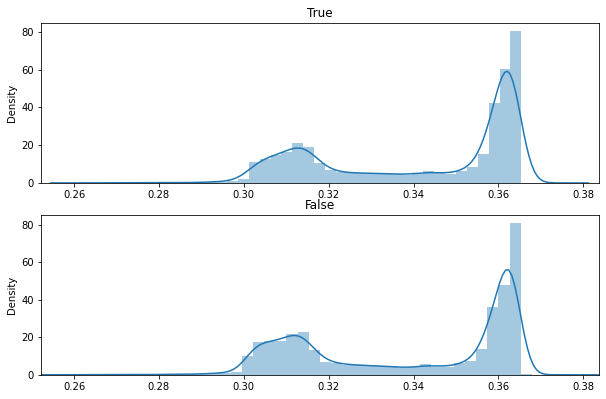

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


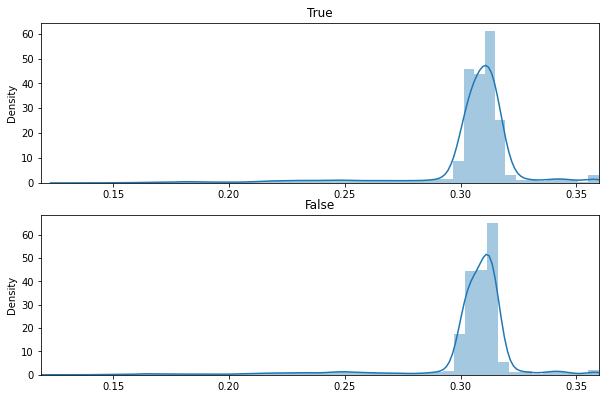

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


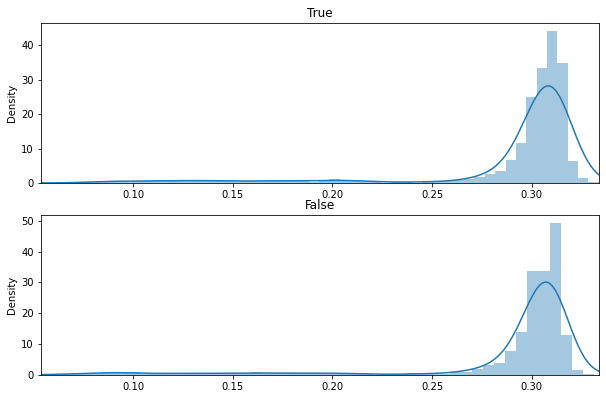

In [ ]:
# Plot the distribution of the scores.

import matplotlib.pyplot as plt
import seaborn as sb


def plot_distribution(model, ds, labels):
  scores = model.predict(ds.batch(batch_size))

  mn = scores.min()
  mx = scores.max()

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(311)
  plt.title('True')
  sb.distplot(scores[labels > 0.5])
  plt.xlim([mn, mx])


  ax = fig.add_subplot(312)
  plt.title('False')
  sb.distplot(scores[labels < 0.5])

  plt.xlim([mn, mx])
  plt.show()


plot_distribution(model, train_ds, train_target)
plot_distribution(model, valid_ds, valid_target)
plot_distribution(model, test_ds, test_target)